In [131]:
import requests
import pandas as pd


# Create function to get raw json return from FRED database
def get_series_json(series_id, start, end, api_key='fbf2a3cac76ec733ee2b8c01ab036950'
                , file_type='json'):
    url_base = 'https://api.stlouisfed.org/fred/series/observations'
    url = f'{url_base}?series_id={series_id}'
    if start is not None:
        start = pd.to_datetime(start, errors='raise')
        url += '&observation_start=' + start.strftime('%Y-%m-%d')
    if end is not None:
        end = pd.to_datetime(end, errors='raise')
        url += '&observation_end=' + end.strftime('%Y-%m-%d')
    url += f'&api_key={api_key}&file_type={file_type}'
    
    try:
        resp = requests.get(url)
        resp.raise_for_status()  # Raise exception if invalid response
        return resp
    except Exception as e:
        errmsg = resp.json()['error_message'].replace('series', f'series {series_id}')
        print(f'Error: {resp.status_code}\n{errmsg}')
        return None
    

# # Create a function to get a single series from FRED database
# def get_series(series_id, start, end, api_key='fbf2a3cac76ec733ee2b8c01ab036950'
#                , file_type='json', fill_na=True):
#     url_base = 'https://api.stlouisfed.org/fred/series/observations'
#     url = f'{url_base}?series_id={series_id}'
#     if start is not None:
#         start = pd.to_datetime(start, errors='raise')
#         url += '&observation_start=' + start.strftime('%Y-%m-%d')
#     if end is not None:
#         end = pd.to_datetime(end, errors='raise')
#         url += '&observation_end=' + end.strftime('%Y-%m-%d')
    
#     url += f'&api_key={api_key}&file_type={file_type}'
    
    
#     try:
#         resp = requests.get(url)
#         resp.raise_for_status()  # Raise exception if invalid response
#     except Exception as e:
#         errmsg = resp.json()['error_message'].replace('series', f'series {series_id}')
#         print(f'Error: {resp.status_code}\n{errmsg}')
#         return None
    
# Create function to transform valid json response from FRED into a dataframe
def transform_series_json(resp, series_id):
    # dfdict = {}
    # for i in resp.json()['observations']:
    #     dt = pd.to_datetime(i['date'], errors='raise')
    #     if i['value'] != '.':
    #         rate = float(i['value'])
    #     else:
    #         rate = None
    #     dfdict[dt] = rate
        
    # return dfdict
    
    obs = pd.DataFrame(resp.pop('observations'))[['date', 'value']]
    obs['date'] = pd.to_datetime(obs['date'])
    obs.set_index('date', inplace=True)
    
    meta = pd.DataFrame({series_id: resp})
    meta.loc['NaNs'] = obs.value_counts()['.']  # Count missing values and add to meta df
    
    return obs, meta
    
        
    # df = pd.DataFrame.from_dict(dfdict, orient='index', columns=[series_id])
    # if fill_na:
    #     df.fillna(method='ffill', inplace=True)  # Fill missing values with last observation
    #     df.fillna(method='bfill', inplace=True)  # Then, fill with next observation
    # return df

# Create function to fill missing values in FRED series datafame
def fill_series_na(df):
    df.fillna(method='ffill', inplace=True)  # Fill missing values with last observation
    df.fillna(method='bfill', inplace=True)  # Then, fill with next observation
    
    return df

# Create a function to get a time series from FRED and return a clean dataframe
def get_series(series_id, start, end, api_key=None, file_type='json', fill_na=None):
    
    fill_na = True if fill_na is None else fill_na  # Default
    # if api_key is None:
    #     api_key = 'fbf2a3cac76ec733ee2b8c01ab036950'
    api_key = 'fbf2a3cac76ec733ee2b8c01ab036950' if api_key is None else api_key
    
    try:
        resp = get_series_json(series_id=series_id, start=start, end=end, api_key=api_key, file_type=file_type)
        df = transform_series_json(resp, series_id=series_id)
        df = pd.DataFrame.from_dict(df, orient='index', columns=[series_id])
    except Exception as e:
        print(f'Error: {e}')
        return None
    
    if fill_na:
        df = fill_series_na(df)
    return df
               

series = 'DEXUSUK'
# series = 'DEXUKUS'
start = '1983-01-01'
end = '2022-12-31'

df = get_series(series_id=series, start=start, end=end, fill_na=False)
df

,DEXUSUK
1983-01-03,1.6235
1983-01-04,1.6210
1983-01-05,1.6210
1983-01-06,1.6065
1983-01-07,1.6100
...,...
2022-12-26,NaN
2022-12-27,1.2032
2022-12-28,1.2034
2022-12-29,1.2060


In [138]:
get_series_json(series_id=series, start=start, end=end).json()['observation_start']

'2010-01-01'

In [213]:
resp = get_series_json(series_id=series, start=start, end=end)
resp = resp.json()
obs = pd.DataFrame(resp.pop('observations'))[['date', 'value']]
obs['date'] = pd.to_datetime(obs['date'])
obs.set_index('date', inplace=True)
meta = pd.DataFrame({series_id: resp})
meta.loc['NaNs'] = obs.value_counts()['.']
meta

,DEXUKUS
count,2608
file_type,json
limit,100000
observation_end,2019-12-31
observation_start,2010-01-01
offset,0
order_by,observation_date
output_type,1
realtime_end,2023-08-13
realtime_start,2023-08-13


In [135]:
# Define function to use the get_series function to get the data for a list of series
# and combine them into one dataframe

def get_multiple_series(series_list, start, end, fill_na=True):
    df = pd.DataFrame()
    for series in series_list:
        try:
            df = pd.concat([df, get_series(series_id=series, start=start, end=end
                                           , fill_na=fill_na)], axis=1)
        except Exception as e:
            print(e)
    return df

series_list = ['DEXUSUK', 'DEXUSEU', 'DEXCHUS',
               'DEXJPUS', 'DEXCAUS', 'DEXUSAL']
start = '2010-01-01'
end = '2019-12-31'

list_df = get_multiple_series(series_list, start=start, end=end)
print(pd.concat([list_df.head(10), list_df.tail(10)], axis=0))
print(list_df.info())

            DEXUSUK  DEXUSEU  DEXCHUS  DEXJPUS  DEXCAUS  DEXUSAL
2010-01-01   1.6109   1.4419   6.8273    92.55   1.0377   0.9133
2010-01-04   1.6109   1.4419   6.8273    92.55   1.0377   0.9133
2010-01-05   1.6009   1.4402   6.8258    91.48   1.0371   0.9143
2010-01-06   1.6016   1.4404   6.8272    92.53   1.0333   0.9189
2010-01-07   1.5912   1.4314   6.8280    93.31   1.0351   0.9168
2010-01-08   1.5993   1.4357   6.8274    92.70   1.0345   0.9218
2010-01-11   1.6146   1.4536   6.8263    91.90   1.0317   0.9295
2010-01-12   1.6181   1.4523   6.8267    90.95   1.0374   0.9242
2010-01-13   1.6288   1.4492   6.8295    91.38   1.0319   0.9225
2010-01-14   1.6320   1.4478   6.8265    91.03   1.0260   0.9306
2019-12-18   1.3078   1.1113   7.0029   109.58   1.3117   0.6854
2019-12-19   1.3034   1.1128   7.0097   109.23   1.3122   0.6887
2019-12-20   1.3036   1.1076   7.0063   109.45   1.3170   0.6902
2019-12-23   1.2917   1.1091   7.0124   109.39   1.3167   0.6917
2019-12-24   1.2955   1.1

In [45]:
list_df

,DEXUSUK,DEXUSEU,DEXCHUS
2019-01-01,NaN,NaN,NaN
2019-01-02,1.2598,1.1357,6.8597
2019-01-03,1.2633,1.1399,6.8708
2019-01-04,1.2740,1.1410,6.8663
2019-01-07,1.2757,1.1468,6.8501
...,...,...,...
2019-12-25,1.2955,1.1084,7.0064
2019-12-26,1.3007,1.1102,6.9949
2019-12-27,1.3090,1.1174,6.9954
2019-12-30,1.3140,1.1217,6.9864


In [2]:
df.isna().value_counts()

DEXUSUK
False      10435
dtype: int64

In [4]:
import plotly.graph_objects as go

trace = go.Scatter(x=df.index, y=df['DEXUSUK'], mode='lines')
data = [trace]
layout = {
    'title': 'USD/GBP Exchange Rate',
    'xaxis_title': 'Date',
    'yaxis_title': 'USD/GBP Rate',
    'width': 1800,
    'height': 1000,
    'hovermode': 'x unified',
    'template': 'seaborn',
    'xaxis': {
        'rangeslider': {
            'visible': True,
        },
    }
}

fig = go.Figure(data=data, layout=layout)
fig.show()

In [5]:
df.resample('W').mean()

,DEXUSUK
1983-01-09,1.61640
1983-01-16,1.58150
1983-01-23,1.57570
1983-01-30,1.54000
1983-02-06,1.52124
...,...
2022-12-04,1.21086
2022-12-11,1.22222
2022-12-18,1.22884
2022-12-25,1.20968


In [11]:
# Calculate seasonal decomposition on the DEXUSUK time series
from statsmodels.tsa.seasonal import seasonal_decompose

# decomp = seasonal_decompose(df)
decomp = seasonal_decompose(df.resample('W').mean(), extrapolate_trend='freq')

# Show decomposition plots
from plotly.subplots import make_subplots

fig = make_subplots(rows=4, cols=1, subplot_titles=['Observed', 'Trend', 'Seasonal', 'Residuals'])

fig.add_trace(go.Scatter(x=decomp.observed.index, y=decomp.observed.values, name='Observed'), row=1, col=1)
fig.add_trace(go.Scatter(x=decomp.trend.index, y=decomp.trend.values, name='Trend'), row=2, col=1)
fig.add_trace(go.Scatter(x=decomp.seasonal.index, y=decomp.seasonal.values, name='Seasonal'), row=3, col=1)
fig.add_trace(go.Scatter(x=decomp.resid.index, y=decomp.resid.values, name='Residuals'), row=4, col=1)

fig.update_layout(width=1800, height=1000, title='Seasonal Decomposition Plot', template='seaborn')

fig.show()

In [12]:
from pmdarima import auto_arima

arimafit = auto_arima(df['DEXUSUK'].dropna(), trace=True)
# arimafit = auto_arima(df['DEXUSUK'].resample('W').mean().dropna(), trace=True)
arimafit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-67558.703, Time=4.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-67542.197, Time=0.82 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-67561.567, Time=0.73 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-67561.321, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-67544.014, Time=0.55 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-67559.733, Time=1.53 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-67559.663, Time=0.98 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-67536.202, Time=0.82 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-67563.399, Time=0.49 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-67561.567, Time=0.80 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-67561.496, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-67563.153, Time=0.50 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-67559.544, Time=1.47 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 14.463 sec

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                10435
Model:               SARIMAX(1, 1, 0)   Log Likelihood               33783.700
Date:                Sun, 13 Aug 2023   AIC                         -67563.399
Time:                        14:24:16   BIC                         -67548.894
Sample:                    01-03-1983   HQIC                        -67558.500
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0453      0.007      6.131      0.000       0.031       0.060
sigma2      9.019e-05   6.39e-07    141.032      0.000    8.89e-05    9.14e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             14146.49
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
train = df['DEXUSUK'].iloc[:-90]
test = df['DEXUSUK'].iloc[-90:]

In [16]:
from statsmodels.tsa.arima.model import ARIMA

mod = ARIMA(train, order=(1,1,0), freq='B')
res = mod.fit()
res.summary()

c:\Users\jtrawic\Anaconda3\envs\d214\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                DEXUSUK   No. Observations:                10345
Model:                 ARIMA(1, 1, 0)   Log Likelihood               33513.246
Date:                Sun, 13 Aug 2023   AIC                         -67022.492
Time:                        14:27:01   BIC                         -67008.003
Sample:                    01-03-1983   HQIC                        -67017.596
                         - 08-26-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0458      0.007      6.193      0.000       0.031       0.060
sigma2      8.982e-05   6.37e-07    141.101      0.000    8.86e-05    9.11e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             14399.82
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Results of Augmented Dickey-Fuller Test:

                   Results 
Test Statistic   -2.270853
p-value           0.181541
Num Lags               1.0
Num Observations   10433.0

Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data may have a unit root and is non-stationary


<Axes: >

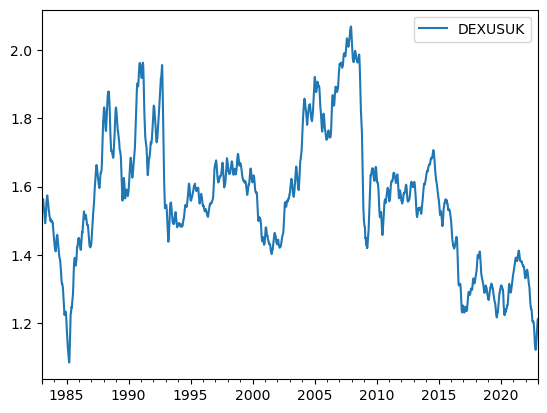

In [32]:
from statsmodels.tsa.stattools import adfuller                                                                                                                                                                              


# Evaluate the stationarity of time series data using Augmented Dickey-Fuller and print results
def adf_test(ts):
    df = adfuller(ts, autolag='AIC')
    results = pd.DataFrame(df[:4], columns=['Results '], dtype=object)
    results.index=['Test Statistic', 'p-value', 'Num Lags', 'Num Observations']
    print('Results of Augmented Dickey-Fuller Test:\n\n', results)
    if df[1] <= 0.05:
        print('\nStrong evidence against the null hypothesis')
        print('Reject the null hypothesis')
        print('Data may have no unit root and is stationary')
    else:
        print('\nWeak evidence against the null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data may have a unit root and is non-stationary')

# Run the ADF test on the raw time series data
adf_test(df)

# Plot 30-day rolling mean
df.rolling(window=30).mean().plot()

In [17]:
res.forecast(10).value_counts()

1.177680    2
1.177685    1
1.177680    1
1.177680    1
1.177680    1
1.177680    1
1.177680    1
1.177680    1
1.177680    1
Name: predicted_mean, dtype: int64

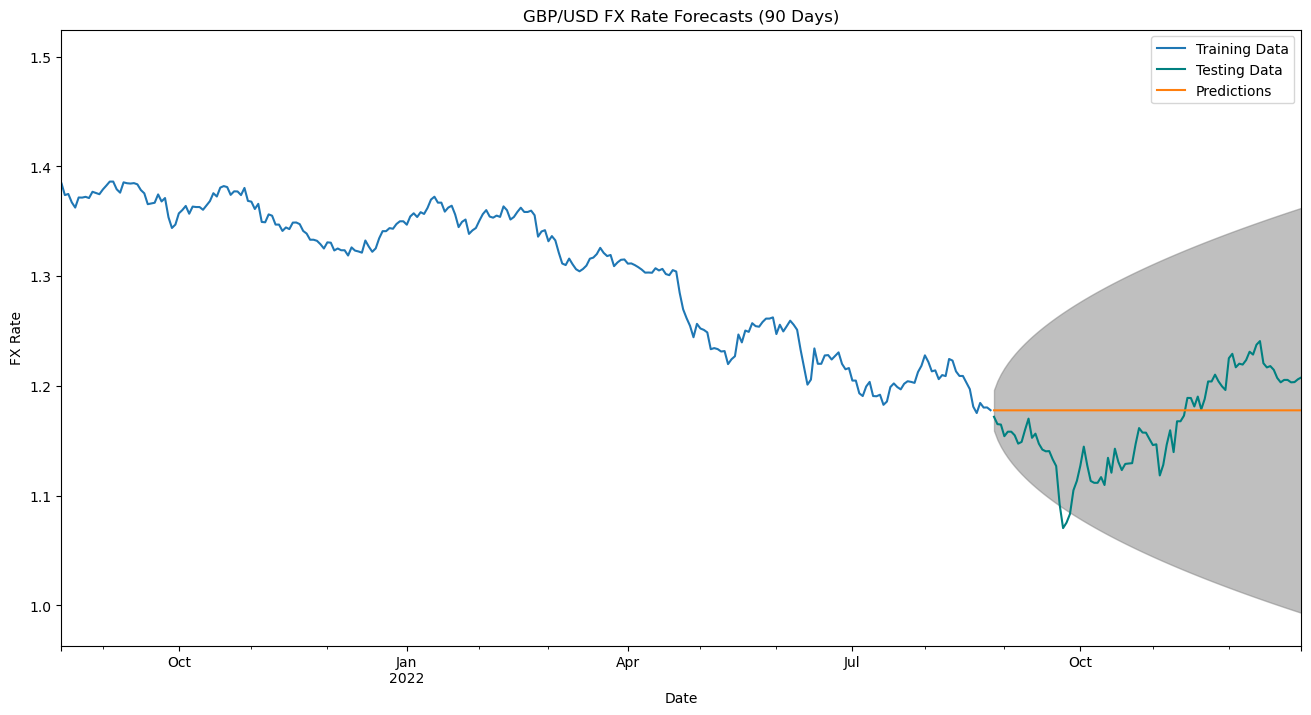

In [22]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_predict

def arima_forecast_plot(model, train, test, title, ylabel, xlabel, start=len(train), end=len(train)+len(test), figsize=(16, 8), plt_ext=-270):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
    train.plot(ax=ax)
    test.plot(ax=ax, color='teal')
    plot_predict(model, start=start, end=end, ax=ax, alpha=0.05)
    
    ax.legend(['Training Data', 'Testing Data', 'Predictions'])
    plt_range_start = train.index[plt_ext]
    plt_range_end = test.index[-1]
    plt_max = max(train.iloc[plt_ext:].max(), test.max()) * 1.1
    plt_min = min(train.iloc[plt_ext:].min(), test.min()) * 0.9
    plt.xlim([plt_range_start, plt_range_end])
    plt.ylim([plt_min, plt_max])
    plt.show()
arima_forecast_plot(res, train, test, title='GBP/USD FX Rate Forecasts (90 Days)', ylabel='FX Rate', xlabel='Date')

matplotlib.figure.Figure

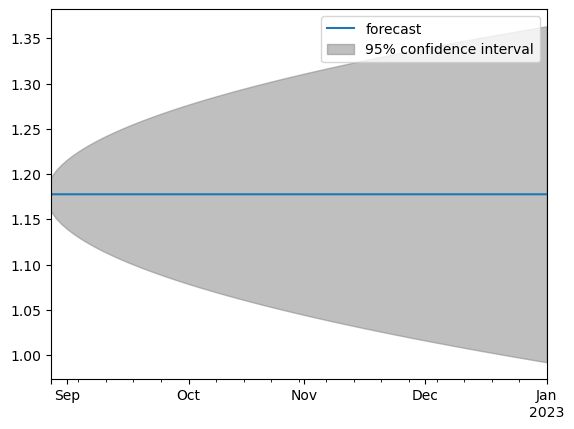

In [26]:
plot_predict(res, len(train), len(test) + len(train)).__class__

In [ ]:
trace = go.Scatter(x=df.index, y=df['DEXUSUK'], mode='lines')
data = [trace]
layout = {
    'title': 'USD/GBP Exchange Rate',
    'xaxis_title': 'Date',
    'yaxis_title': 'USD/GBP Rate',
    'width': 1800,
    'height': 1000,
    'hovermode': 'x unified',
    'template': 'seaborn',
    'xaxis': {
        'rangeslider': {
            'visible': True,
        },
    }
}

fig = go.Figure(data=data, layout=layout)
fig.show()